In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from collections import defaultdict
sns.set_theme(font_scale=1.2)
sns.set_style('white')

def plot_mmd(stat_name, means,ses,xlim=None,show=True,with_title=False,**kwargs):
    sns.lineplot(x = np.arange(len(means)),y = means,**kwargs)
    plt.fill_between(np.arange(len(means)),np.array(means)-np.array(ses)*1.96,np.array(means)+np.array(ses)*1.96,alpha=0.2)
    # plt.title(f'Running mean and standard error of {stat_name}')
    if xlim is not None:
        plt.xlim(xlim)
    if show:
        plt.show()

def plot_mmd_se(stat_name, ses,xlim=None,show=True,with_title=False,**kwargs):
    sns.lineplot(x = np.arange(len(ses)),y = ses,**kwargs)
    # plt.title(f'Running standard error of {stat_name}')
    if xlim is not None:
        plt.xlim(xlim)
    if show:
        plt.show()


In [24]:


mmd_results = defaultdict(dict)
for filename in glob('/mnt/blob/dayhoff/data/mmd_results_v2/*/mmd*.npy'):
    name = filename.split('/')[-1].split('.')[0].replace('mmd_','').replace('GENERATIONS_','')
    if "means" in name:
        mmd_results[name.replace('means_','')]['means'] = np.load(filename)
    elif "std_errors" in name:
        mmd_results[name.replace('std_errors_','')]['std_errors'] = np.load(filename)



sigma_results = defaultdict(dict)
for filename in glob('/mnt/blob/dayhoff/data/mmd_results_v2/*/median_dist*.npy'):
    name = filename.split('/')[-1].split('.')[0].replace('median_dist_','').replace('GENERATIONS_','')
    if "means" in name:
        sigma_results[name.replace('means_','')]['means'] = np.load(filename)
    elif "std_errors" in name:
        sigma_results[name.replace('std_errors_','')]['std_errors'] = np.load(filename)



In [30]:
def result_to_historic(mmd_results):
    results_historic_df = []
    for scenario, stats in mmd_results.items():
        c=1
        for mean,std_error in zip(stats['means'],stats['std_errors']):
            results_historic_df.append({"scenario":scenario,"mean":mean,"std_error":std_error,'sample':c}) 
            c+=1
        
    results_historic_df = pd.DataFrame(results_historic_df).replace({"GIGAREF_CLUSTERED_10M":"GGR",
                            "UNIREF50_10M":"UR50",
                            "RFDIFFUSION_UNFILTERED":"BBR-u",
                            "RFDIFFUSION_BOTH_FILTER":"BBR-n",
                            "RFDIFFUSION_SCRMSD":"BBR-s",
                            "DAYHOFF":"DR",
                            "_": " vs. "
                            },
                            regex=True
    )
    results_historic_df['dataset'] = results_historic_df['scenario'].apply(lambda x: x.split(' ')[-1])
    results_historic_df['model'] = results_historic_df['scenario'].apply(lambda x: x.split(' ')[0])

    return results_historic_df

mmd_results_historic_df = result_to_historic(mmd_results)
sigma_results_historic_df = result_to_historic(sigma_results)

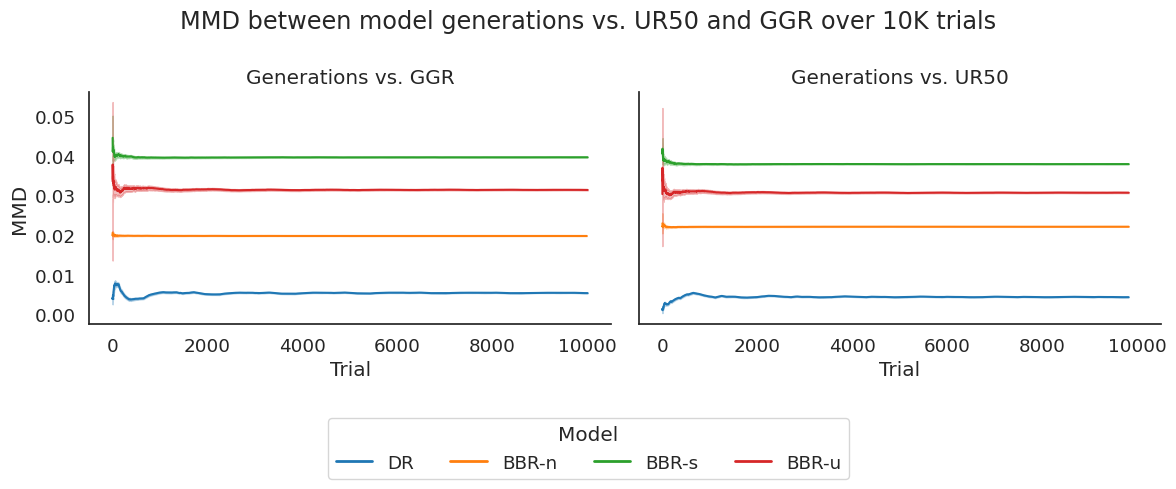

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Assuming mmd_results_historic_df is your DataFrame.
# Create a color palette and map models to colors.
palette = sns.color_palette("tab10")
models = mmd_results_historic_df['model'].unique()
model_color_map = dict(zip(models, palette))

# Define a custom plotting function for each facet.
def plot_facet(data, color, **kwargs):
    ax = plt.gca()  # get current axis
    # Plot each model's line and fill between the CI.
    for model, group in data.groupby("model"):
        ax.plot(group['sample'], group['mean'], label=model, color=model_color_map[model])
        ax.fill_between(
            group['sample'],
            group['mean'] - group['std_error'] * 1.96,
            group['mean'] + group['std_error'] * 1.96,
            alpha=0.3,
            color=model_color_map[model]
        )
    ax.set_xlabel("Trial")
    ax.set_ylabel("MMD")

# Create a FacetGrid with one column per dataset.
# Adjust the "height" and "aspect" to control the size of each subplot.
g = sns.FacetGrid(mmd_results_historic_df, col="dataset", height=4, aspect=1.5)
g.map_dataframe(plot_facet)

# Set titles for each facet (each will display its dataset name).
g.set_titles(col_template="Generations vs. {col_name}")

# Add a common main title.
plt.subplots_adjust(top=0.85)
g.fig.suptitle("MMD between model generations vs. UR50 and GGR over 10K trials")

# Create a custom legend for the models.
legend_elements = [
    Line2D([0], [0], color=model_color_map[model], lw=2, label=model)
    for model in models
]
g.fig.legend(
    handles=legend_elements,
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(models)
)

plt.tight_layout()
plt.show()


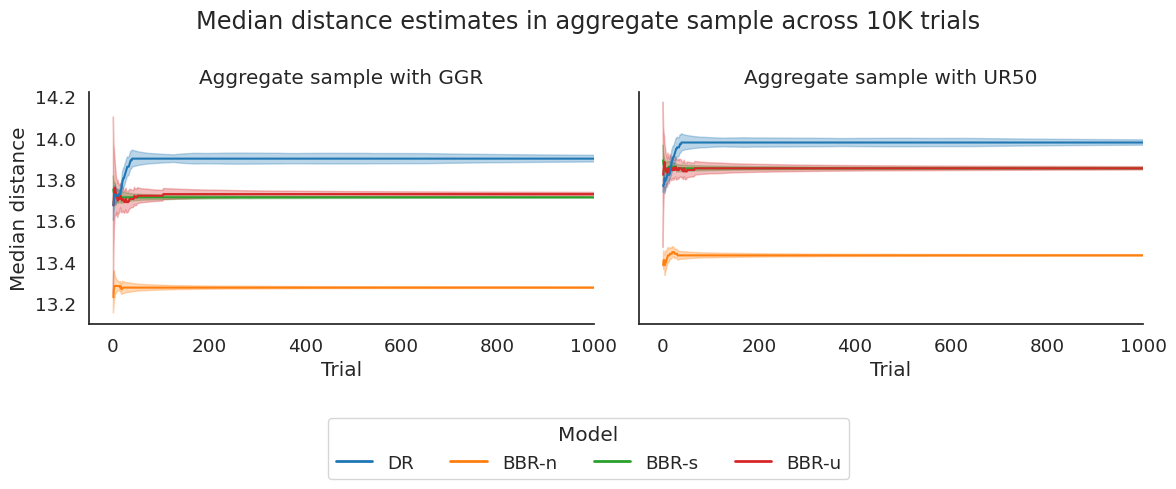


    Estimated median pairwise distances in aggregate samples over 10,000 Monte Carlo trials (sample size = 1,000).
    The median heuristic is used to estimate the bandwidth parameter (σ) of the RBF kernel for Maximum Mean Discrepancy (MMD).
    Shown are the convergence trajectories of the median distance estimate across four generation methods (DR, BBR-n, BBR-s, BBR-u), applied to two different training datasets: GGR and UR50.
    "DR" refers to Deterministic Replay; "BBR-n", "BBR-s", and "BBR-u" correspond to variants of the BBR method using normal, stratified, and uniform sampling strategies, respectively.
    Shaded regions indicate variability across trials. Estimates stabilize rapidly, indicating reliability of the median heuristic under compute constraints.
    


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Assuming mmd_results_historic_df is your DataFrame.
# Create a color palette and map models to colors.
palette = sns.color_palette("tab10")
models = mmd_results_historic_df['model'].unique()
model_color_map = dict(zip(models, palette))

# Define a custom plotting function for each facet.
def plot_facet(data, color, **kwargs):
    ax = plt.gca()  # get current axis
    # Plot each model's line and fill between the CI.
    for model, group in data.groupby("model"):
        ax.plot(group['sample'], group['mean'], label=model, color=model_color_map[model])
        ax.fill_between(
            group['sample'],
            group['mean'] - group['std_error'] * 1.96,
            group['mean'] + group['std_error'] * 1.96,
            alpha=0.3,
            color=model_color_map[model]
        )
    ax.set_xlabel("Trial")
    ax.set_ylabel("Median distance")

# Create a FacetGrid with one column per dataset.
# Adjust the "height" and "aspect" to control the size of each subplot.
g = sns.FacetGrid(sigma_results_historic_df, col="dataset", height=4, aspect=1.5)
g.map_dataframe(plot_facet)

# Set titles for each facet (each will display its dataset name).
g.set_titles(col_template="Aggregate sample with {col_name}")

# Add a common main title.
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Median distance estimates in aggregate sample across 10K trials")

# Create a custom legend for the models.
legend_elements = [
    Line2D([0], [0], color=model_color_map[model], lw=2, label=model)
    for model in models
]
g.fig.legend(
    handles=legend_elements,
    title="Model",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(models)
)
# plt.xscale("log")
plt.xlim(-50,1_000)
plt.tight_layout()
plt.show()
print(

    """
    Estimated median pairwise distances in aggregate samples over 10,000 Monte Carlo trials (sample size = 1,000).
    The median heuristic is used to estimate the bandwidth parameter (σ) of the RBF kernel for Maximum Mean Discrepancy (MMD).
    Shown are the convergence trajectories of the median distance estimate across four generation methods (DR, BBR-n, BBR-s, BBR-u), applied to two different training datasets: GGR and UR50.
    "DR" refers to Deterministic Replay; "BBR-n", "BBR-s", and "BBR-u" correspond to variants of the BBR method using normal, stratified, and uniform sampling strategies, respectively.
    Shaded regions indicate variability across trials. Estimates stabilize rapidly, indicating reliability of the median heuristic under compute constraints.
    """
)

In [52]:
mmd_results_df = pd.DataFrame([{'scenario':d,'mean':mmd_results[d]['means'][-1], 'std_error':mmd_results[d]['std_errors'][-1]} for d in mmd_results.keys()])
mmd_results_df['95% CI'] = mmd_results_df.apply(lambda x: (x['mean'] - 1.96*x['std_error'], x['mean'] + 1.96*x['std_error']), axis=1)

mmd_results_df = mmd_results_df.replace({"GIGAREF_CLUSTERED_10M":"GGR",
                        "UNIREF50_10M":"UR50",
                        "RFDIFFUSION_UNFILTERED":"BBR-u",
                        "RFDIFFUSION_BOTH_FILTER":"BBR-n",
                        "RFDIFFUSION_SCRMSD":"BBR-s",
                        "DAYHOFF":"DR",
                        "_": " vs. "
                        },
                        regex=True
).sort_values(by='mean', ascending=True)

mmd_results_df.to_parquet('/mnt/blob/dayhoff/data/mmd_results_v2/mmd_results.parquet',index=False)
mmd_results_df.to_parquet('../data/mmd_results_v2/mmd_results.parquet',index=False)

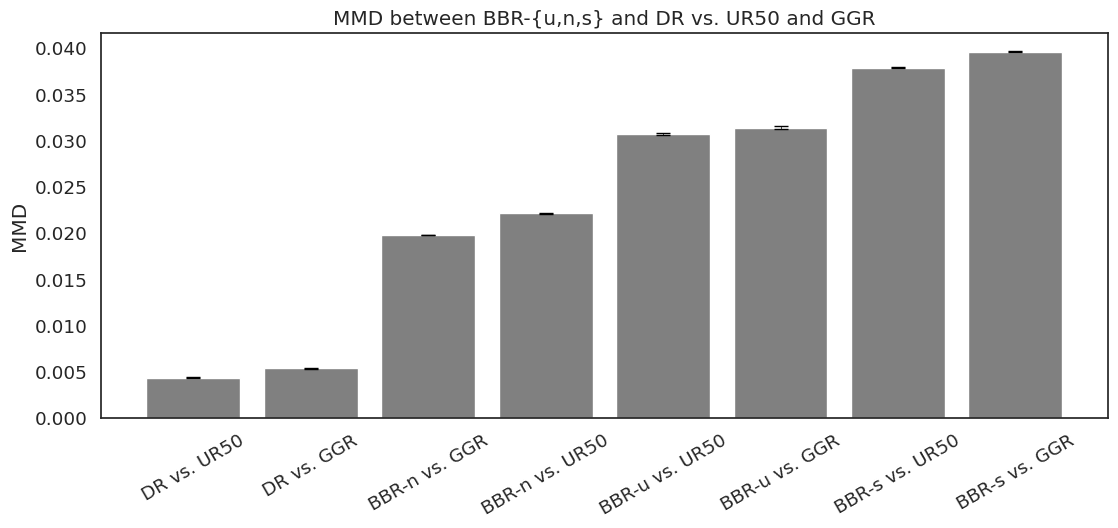

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(font_scale=1.2)
sns.set_style('white')
mmd_results_df = pd.read_parquet('../data/mmd_results_v2/mmd_results.parquet')

plt.figure(figsize=(13, 5))
sns.barplot(x='scenario', y='mean', data=mmd_results_df, color="grey", errorbar=None)
plt.errorbar(mmd_results_df['scenario'],mmd_results_df['mean'], yerr=mmd_results_df['std_error']*1.96, fmt='.', capsize=5,markersize=0, ecolor='black', elinewidth=0.5)
# sns.despine()
plt.xticks(rotation=30)
plt.title("MMD between BBR-{u,n,s} and DR vs. UR50 and GGR")
plt.ylabel("MMD")
plt.xlabel("")
plt.show()

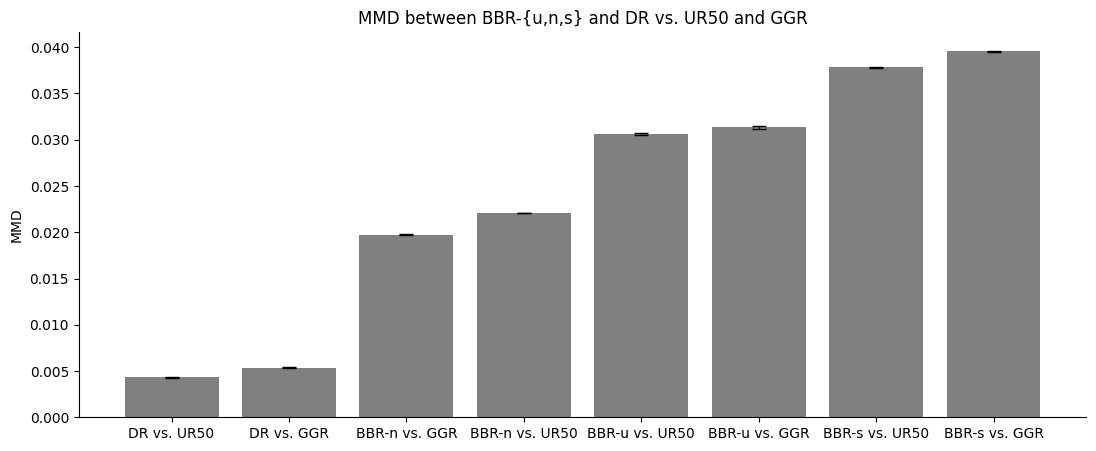

# Exploring

In [3]:
# Create synthetic real and fake datasets based on univariate normal distributions
from torch.utils.data import TensorDataset
d = 1
sample_size = 1_000_000
mean_real = torch.ones(d)*5
var_real = torch.ones(d)*16

mean_fake = torch.ones(d)*5
var_fake = torch.ones(d)*16

class TensorDatasetWithoutTargets(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, index):
        return self.data_tensor[index]
ds_real = TensorDatasetWithoutTargets(torch.distributions.MultivariateNormal(mean_real, torch.diag(var_real)).sample((sample_size,)))
ds_fake = TensorDatasetWithoutTargets(torch.distributions.MultivariateNormal(mean_fake, torch.diag(var_fake)).sample((sample_size,)))
# Create simple dataloaders from synthetic data tensors



In [41]:

bs=10000

dl_real = torch.utils.data.DataLoader(
    ds_real,
    batch_size=bs,
    num_workers=2,
    pin_memory=True,
    shuffle=False
)

dl_fake = torch.utils.data.DataLoader(
    ds_fake,
    batch_size=bs,
    num_workers=2,
    pin_memory=True,
    shuffle=False
)


#Params
num_iterations = sample_size//bs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_samples_real = len(ds_real)
num_samples_fake = len(ds_fake)
max_samples = min(num_samples_real, num_samples_fake)
num_iterations = min(num_iterations,max_samples)

get_running_stats
(mean_means,
 mean_stds,
 mean_std_errors) = get_running_stats(dl_real, num_iterations, device = device)

100%|██████████| 100/100 [00:01<00:00, 65.82it/s]


1


100%|██████████| 1000000/1000000 [13:05<00:00, 1272.52it/s]


10


100%|██████████| 100000/100000 [01:16<00:00, 1300.69it/s]


100


100%|██████████| 10000/10000 [00:08<00:00, 1247.68it/s]


1000


100%|██████████| 1000/1000 [00:01<00:00, 727.79it/s]

10000



100%|██████████| 100/100 [00:01<00:00, 71.18it/s]


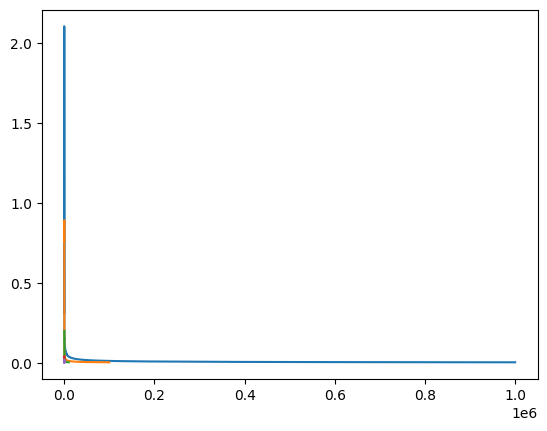

In [ ]:
mean_std_errors_all = []
for bs in [1,10,100,1000,10000]:
    print(bs)

    dl_real = torch.utils.data.DataLoader(
        ds_real,
        batch_size=bs,
        num_workers=2,
        pin_memory=True,
        shuffle=False
    )

    dl_fake = torch.utils.data.DataLoader(
        ds_fake,
        batch_size=bs,
        num_workers=2,
        pin_memory=True,
        shuffle=False
    )


    #Params
    num_iterations = sample_size//bs
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_samples_real = len(ds_real)
    num_samples_fake = len(ds_fake)
    max_samples = min(num_samples_real, num_samples_fake)
    num_iterations = min(num_iterations,max_samples)

    get_running_stats
    (mean_means,
    mean_stds,
    mean_std_errors) = get_running_stats(dl_real, num_iterations, device = device)

    mean_std_errors_all.append(mean_std_errors)


In [ ]:
sns.lineplot(x = np.arange(len(mean_std_errors)),y = mean_std_errors)
plt.show()

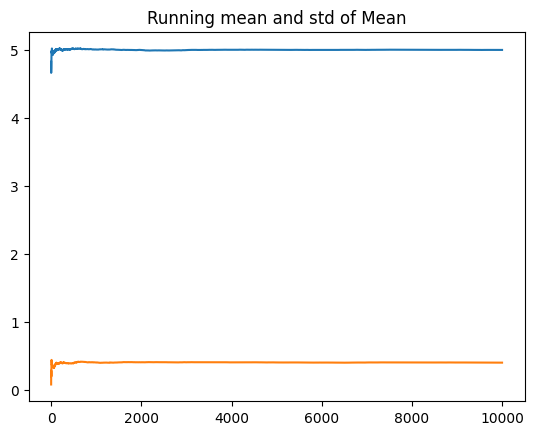

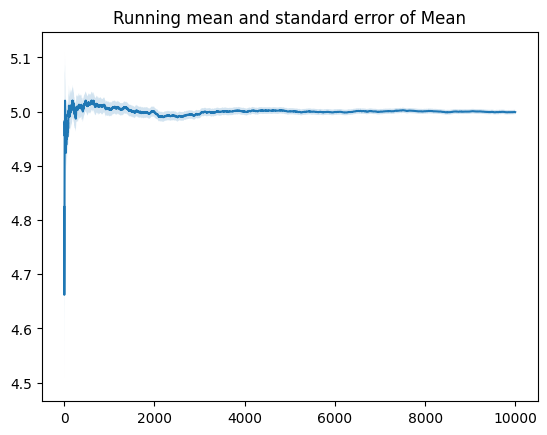

In [38]:
plot_stats(
    "Mean",
    mean_means, 
    mean_stds,
    mean_std_errors
    )

In [ ]:
mean_means[-1], mean_stds[-1], mean_std_errors[-1]

(np.float64(4.999227218465816),
 np.float64(0.4020883788891122),
 np.float64(0.004020883788891122))

In [40]:
ds_real[:].mean(), ds_real[:].std(), ds_real[:].std()/np.sqrt(len(ds_real))

(tensor(4.9992), tensor(4.0036), tensor(0.0040))

# Frechet

In [ ]:
ds_real = ProteinLabelDistributions(
    dataset_name ="RFDIFFUSION_GENERATIONS_BOTH_FILTER",
    h5_paths = glob('../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits*'),
    max_workers = 8,
    cache=False
) #3min 48seg, | 


../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/RFDIFFUSION_GENERATIONS_BOTH_FILTER.pt
Reading from HDF5 files...


In [ ]:
import dask.array as da
import h5py
from dask import delayed
from dask.distributed import Client

dask_arrays=[]

for file in h5_paths:
    shape = get_h5_shape(file)
    # Wrap the read function in a delayed call.
    delayed_data = delayed(load_h5_as_array)(file)
    # Create a Dask array from the delayed object using the known shape.
    d_arr = da.from_delayed(delayed_data, shape=shape, dtype='float')
    dask_arrays.append(d_arr)



# Concatenate along the axis corresponding to files.
# Here we assume that each file contains a chunk along the first dimension.
data = da.concatenate(dask_arrays, axis=0)

In [37]:
np.save('test.npy',ds_real.data.numpy())

In [ ]:
batch_size = 1_000
max_workers = 8
cache = True

ds_real = ProteinLabelDistributions(
    dataset_name ="RFDIFFUSION_GENERATIONS_BOTH_FILTER",
    h5_paths = glob('../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits*')[:50],
    max_workers = max_workers,
    cache=cache
)

ds_fake = ProteinLabelDistributions(
    dataset_name ="RFDIFFUSION_GENERATIONS_BOTH_FILTER",
    h5_paths = glob('../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits*')[:50],
    max_workers = max_workers,
    cache=cache
)

dl_real = torch.utils.data.DataLoader(ds_real, batch_size=batch_size, shuffle=True)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=True)

../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/RFDIFFUSION_GENERATIONS_BOTH_FILTER.pt
Loading from PT file...


In [23]:
ds_real[:3]

tensor([[8.2254e-06, 7.4100e-04, 6.6681e-03,  ..., 8.6260e-04, 9.0866e-03,
         7.2060e-03],
        [6.6423e-04, 2.2766e-02, 9.6359e-03,  ..., 1.4305e-06, 1.5354e-04,
         1.9968e-05],
        [2.4002e-02, 2.9083e-02, 2.1362e-02,  ..., 7.1526e-06, 8.2302e-04,
         3.8004e-04]], dtype=torch.float16)

In [ ]:
import os
from glob import glob
from tqdm import tqdm

In [6]:
import torch
import torch.nn as nn

class IncrementalStats(nn.Module):
    """
    A PyTorch module to incrementally compute the mean and covariance for a stream of feature vectors.

    For a set of N feature vectors x1, x2, …, xN (each of dimension d), the sample mean and covariance are computed as:
    
      μ = (1/N) ∑ xᵢ
      Σ = 1/(N-1) ( Q - N μ μᵀ )
    
    where:
      S = ∑ xᵢ    (running sum)
      Q = ∑ xᵢ xᵢᵀ   (running sum of outer products)
    
    Usage:
        stats = IncrementalStats(num_features)
        stats.update(batch)   # where batch is a tensor of shape (batch_size, num_features)
        mean = stats.get_mean()
        cov = stats.get_covariance()
    """
    def __init__(self, num_features,device='cuda'):
        super(IncrementalStats, self).__init__()
        self.num_features = num_features
        # Register buffers so that they move with the module's device and are not treated as learnable parameters.
        self.register_buffer("n", torch.tensor(0, dtype=torch.long, device=device))
        self.register_buffer("S", torch.zeros(num_features,device=device))
        self.register_buffer("Q", torch.zeros(num_features, num_features,device=device))

    def update(self, batch: torch.Tensor):
        """
        Update the running statistics with a new batch of feature vectors.

        Args:
            batch (torch.Tensor): A tensor of shape (batch_size, num_features)
        """
        batch = batch.to(self.S.device)
        batch_size = batch.size(0)
        # Update the running sum S and the running sum of outer products Q
        self.S += batch.sum(dim=0)
        self.Q += batch.t() @ batch
        self.n += batch_size

    def get_mean(self) -> torch.Tensor:
        """
        Returns the mean vector computed so far.

        Returns:
            torch.Tensor: Mean vector of shape (num_features,)
        """
        if self.n.item() == 0:
            raise ValueError("No samples have been added yet.")
        return self.S / self.n.float()

    def get_covariance(self) -> torch.Tensor:
        """
        Returns the covariance matrix computed so far.

        Returns:
            torch.Tensor: Covariance matrix of shape (num_features, num_features)
        """
        mean = self.get_mean()
        # Compute the covariance matrix using the running sums:
        # Q - n * (mean outer mean) = Q - n * (mean @ mean.T)
        cov_matrix = self.Q - self.n.float() * (mean.unsqueeze(1) @ mean.unsqueeze(0))
        return cov_matrix / (self.n.float() - 1)

    def reset(self):
        """
        Resets the running statistics.
        """
        self.n.zero_()
        self.S.zero_()
        self.Q.zero_()

def frechet_distance(mu_x, sigma_x, mu_y, sigma_y):
    a = (mu_x - mu_y).square().sum()
    b = sigma_x.trace() + sigma_y.trace()
    c = torch.linalg.eigvals(sigma_x @ sigma_y).sqrt().real.sum()
    return a + b - 2 * c

# Example usage:


In [7]:
from torcheval.metrics import FrechetInceptionDistance
import torch


def load_h5_as_array(file_path,key = 'logits_df'):
    # Open the file in read mode and load the desired dataset.
    
    with h5py.File(file_path, 'r') as f:
        # Assuming data is stored in the first dataset
        return f[key]['block0_values'][:]


# load_h5_as_array(files[0],key = 'logits_df')

files = glob('../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits*')[:50]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
stats_x = IncrementalStats(num_features=32102,device=device)
stats_y = IncrementalStats(num_features=32102,device=device)

for file in tqdm(files):
    batch = torch.sigmoid(torch.from_numpy(load_h5_as_array(file,key = 'logits_df')).to(device))
    stats_x.update(batch)
    stats_y.update(batch) # TODO: Change this 
    break
   
mean_x = stats_x.get_mean()
cov_x = stats_x.get_covariance()
mean_y = stats_y.get_mean()
cov_y = stats_y.get_covariance()


  0%|          | 0/50 [00:03<?, ?it/s]


In [8]:
cov_y.shape

torch.Size([32102, 32102])

In [ ]:
fd = frechet_distance(mean_x, cov_x, mean_y, cov_y)

In [ ]:

def frechet_distance(mu_x, sigma_x, mu_y, sigma_y):
    a = (mu_x - mu_y).square().sum()
    b = sigma_x.trace() + sigma_y.trace()
    eigvals = torch.linalg.eigh(sigma_x @ sigma_y, UPLO='U').eigenvalues
    c = torch.sqrt(eigvals.real).sum()
    return a + b - 2 * c
fd = frechet_distance(mean_x, cov_x, mean_y, cov_y)

In [22]:
mean_x.shape

torch.Size([32102])

In [ ]:
def frechet_distance(mu_x, sigma_x, mu_y, sigma_y):
    a = (mu_x - mu_y).square().sum()
    b = sigma_x.trace() + sigma_y.trace()
    c = torch.linalg.eigvals(sigma_x @ sigma_y).sqrt().real.sum()
    return a + b - 2 * c
fd2 = frechet_distance(mean_x, cov_x, mean_y, cov_y)
fd2

In [ ]:
frechet_distance(mean_x, cov_x, mean_y, cov_y)

In [10]:
files = glob('../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits*')[:1]
batch = torch.from_numpy(load_h5_as_array(files[0],key = 'logits_df')).to('cuda')
stats_x = IncrementalStats(num_features=32102)


In [11]:
stats_x.update(batch)


In [ ]:
torch.cov(torch.sigmoid(torch.tensor(concatenated[:10000,:2048]).to('cuda')))

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.63 GiB. GPU 0 has a total capacity of 79.25 GiB of which 1013.62 MiB is free. Including non-PyTorch memory, this process has 78.25 GiB memory in use. Of the allocated memory 76.97 GiB is allocated by PyTorch, and 798.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
mmd_rbf(torch.sigmoid(torch.tensor(concatenated[:10000]).to('cuda')),
         torch.sigmoid(torch.tensor(concatenated[:10000]).to('cuda')), sigma=3.0)

tensor(0., device='cuda:0', dtype=torch.float16)

In [21]:
import torch
import torch.nn as nn

class IncrementalStats(nn.Module):
    """
    A PyTorch module to incrementally compute the mean and covariance for a stream of feature vectors.

    For a set of N feature vectors x1, x2, …, xN (each of dimension d), the sample mean and covariance are computed as:
    
      μ = (1/N) ∑ xᵢ
      Σ = 1/(N-1) ( Q - N μ μᵀ )
    
    where:
      S = ∑ xᵢ    (running sum)
      Q = ∑ xᵢ xᵢᵀ   (running sum of outer products)
    
    Usage:
        stats = IncrementalStats(num_features)
        stats.update(batch)   # where batch is a tensor of shape (batch_size, num_features)
        mean = stats.get_mean()
        cov = stats.get_covariance()
    """
    def __init__(self, num_features):
        super(IncrementalStats, self).__init__()
        self.num_features = num_features
        # Register buffers so that they move with the module's device and are not treated as learnable parameters.
        self.register_buffer("n", torch.tensor(0, dtype=torch.long))
        self.register_buffer("S", torch.zeros(num_features))
        self.register_buffer("Q", torch.zeros(num_features, num_features))

    def update(self, batch: torch.Tensor):
        """
        Update the running statistics with a new batch of feature vectors.

        Args:
            batch (torch.Tensor): A tensor of shape (batch_size, num_features)
        """
        batch = batch.to(self.S.device)
        batch_size = batch.size(0)
        # Update the running sum S and the running sum of outer products Q
        self.S += batch.sum(dim=0)
        self.Q += batch.t() @ batch
        self.n += batch_size

    def get_mean(self) -> torch.Tensor:
        """
        Returns the mean vector computed so far.

        Returns:
            torch.Tensor: Mean vector of shape (num_features,)
        """
        if self.n.item() == 0:
            raise ValueError("No samples have been added yet.")
        return self.S / self.n.float()

    def get_covariance(self) -> torch.Tensor:
        """
        Returns the covariance matrix computed so far.

        Returns:
            torch.Tensor: Covariance matrix of shape (num_features, num_features)
        """
        mean = self.get_mean()
        # Compute the covariance matrix using the running sums:
        # Q - n * (mean outer mean) = Q - n * (mean @ mean.T)
        cov_matrix = self.Q - self.n.float() * (mean.unsqueeze(1) @ mean.unsqueeze(0))
        return cov_matrix / (self.n.float() - 1)

    def reset(self):
        """
        Resets the running statistics.
        """
        self.n.zero_()
        self.S.zero_()
        self.Q.zero_()

def frechet_distance(mu_x, sigma_x, mu_y, sigma_y):
    a = (mu_x - mu_y).square().sum()
    b = sigma_x.trace() + sigma_y.trace()
    c = torch.linalg.eigvals(sigma_x @ sigma_y).sqrt().real.sum()
    return a + b - 2 * c

# Example usage:


In [ ]:
frechet_distance(stats.get_mean(), stats.get_covariance(),stats.get_mean(), stats.get_covariance())

tensor(7609.6777)

In [11]:
X = torch.sigmoid(torch.tensor(pd.read_hdf(
    '../data/generation_annotations/DAYHOFF_GENERATIONS/test_1_logits_DAYHOFF_GENERATIONS_PATH_12_rank_0_1000.h5',
    key='logits_df').values).to('cuda'))

Y = torch.sigmoid(torch.tensor(pd.read_hdf(
    '../data/generation_annotations/RFDIFFUSION_GENERATIONS_BOTH_FILTER/test_1_logits_RFDIFFUSION_GENERATIONS_BOTH_FILTER_PATH_12_rank_0_1000.h5',
    key='logits_df').values).to('cuda'))

In [1]:
np.log(10)

NameError: name 'np' is not defined

In [23]:
mmd_rbf(torch.sigmoid(X), torch.sigmoid(Y), sigma=3.0)

tensor(-3.9492, device='cuda:0', dtype=torch.float16)

In [12]:
XX = torch.matmul(X, X.T)
XY = torch.matmul(X, Y.T)
YY = torch.matmul(Y, Y.T)


In [18]:
r2 = lambda x: (x.diag().unsqueeze(0) + x.diag().unsqueeze(1) - 2 * x).fill_diagonal_(0)
r2(YY)

tensor([[ 0.0000, 14.7969, 16.7031,  ..., 15.3594, 29.5000, 12.9766],
        [14.7969,  0.0000, 16.9219,  ...,  8.7656, 23.9688, 10.5312],
        [16.7031, 16.9219,  0.0000,  ..., 18.1094, 25.7500, 19.0156],
        ...,
        [15.3594,  8.7656, 18.1094,  ...,  0.0000, 24.5938, 12.2031],
        [29.5000, 23.9688, 25.7500,  ..., 24.5938,  0.0000, 28.0938],
        [12.9766, 10.5312, 19.0156,  ..., 12.2031, 28.0938,  0.0000]],
       device='cuda:0', dtype=torch.float16)

In [ ]:

r2 = lambda x: (x.diag().unsqueeze(0) + x.diag().unsqueeze(1) - 2 * x).fill_diagonal_(0)

k_xx = torch.exp(-r2(XX) / (2 * sigma**2))
k_xy = torch.exp(-r2(XY) / (2 * sigma**2))
k_yy = torch.exp(-r2(YY) / (2 * sigma**2))